In [5]:
# import libraries
import pandas as pd
import dask.dataframe as dd
import os

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import neighbors
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
# load client and invoice datasets
client_train = pd.read_csv('data/client_train.csv')
client_test = pd.read_csv('data/client_test.csv')

invoice_train = pd.read_parquet('data/invoice_train_compressed.csv.parquet')
invoice_test = pd.read_parquet('data/invoice_test_compressed.csv.parquet')

In [7]:
# merge client and invoice training and testing dataset
merged_df = pd.merge(invoice_train, client_train, on='client_id', how='inner')

merged_test = pd.merge(invoice_test, client_test, on='client_id', how='inner')

In [8]:
from sklearn.preprocessing import LabelEncoder

# Define the list of categorical columns
categorical_columns = ['disrict', 'client_catg', 'region', 'tarif_type', 
                       'counter_statue', 'reading_remarque', 'counter_type']

# Apply Label Encoding to each categorical feature
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    merged_df[col] = le.fit_transform(merged_df[col].astype(str))  # Convert to string in case there are mixed types
    label_encoders[col] = le  # Store the encoder for potential inverse_transform

# Verify the encoding
print(merged_df[categorical_columns].head())

   disrict  client_catg  region  tarif_type  counter_statue  reading_remarque  \
0        0            0       0           1               0                 6   
1        0            0       0           1               0                 4   
2        0            0       0           1               0                 6   
3        0            0       0           1               0                 6   
4        0            0       0           1               0                 7   

   counter_type  
0             0  
1             0  
2             0  
3             0  
4             0  


In [9]:
features = [
    'tarif_type', 'counter_number', 'counter_code', 'reading_remarque',
    'counter_coefficient', 'consommation_level_1', 'consommation_level_2',
    'consommation_level_3', 'consommation_level_4', 'old_index', 'new_index',
    'months_number', 'disrict', 'client_catg', 'region', 'counter_statue', 'counter_type'
]

In [10]:
from sklearn.model_selection import train_test_split

# Partion the features from the class to predict
df_X = merged_df[features]
df_y = merged_df['target'].astype(int)  # Convert 'target' to integer (1/0)  # Convert 'Fraud'/'Not Fraud' to 1/0

# Split the training data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=1)

print ("Number of training instances: ", len(X_train), "\nNumber of test instances: ", len(X_test))

Number of training instances:  3133724 
Number of test instances:  1343025


In [11]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

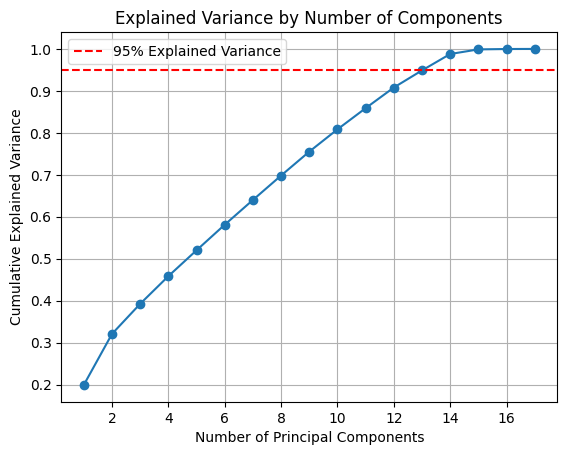

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Fit PCA on the full dataset or a sample
pca = PCA().fit(X_train_scaled)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Apply PCA with a fixed number of components 
pca = PCA(n_components=13, random_state=1)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Number of PCA components: {X_train_pca.shape[1]}")

Number of PCA components: 13


In [14]:
# Check the class distribution in the training set
print("Number of training instances: ")
print(len(X_train_pca))

class_distribution = y_train.value_counts(normalize=True)

print("Class distribution in the training set:")
print(class_distribution)


Number of training instances: 
3133724
Class distribution in the training set:
target
0    0.92107
1    0.07893
Name: proportion, dtype: float64


In [15]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)

print("Number of training instances after SMOTE: ")
print(len(X_train_resampled))

print("Class distribution in resampled training set:")
print(y_train_resampled.value_counts(normalize=True))

Number of training instances after SMOTE: 
5772760
Class distribution in resampled training set:
target
0    0.5
1    0.5
Name: proportion, dtype: float64


In [16]:
# Take a 5% sample of the training data for tuning
sample_size = int(0.05 * len(X_train_resampled))
sample_indices = np.random.choice(len(X_train_resampled), sample_size, replace=False)
X_sample = X_train_resampled[sample_indices]
y_sample = y_train_resampled.iloc[sample_indices]

In [28]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn import neighbors

# Define the objective function for Optuna
def objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 21, step=2)
    metric = trial.suggest_categorical('metric', ['manhattan', 'euclidean', 'chebyshev'])
    
    knn = neighbors.KNeighborsClassifier(
        n_neighbors=n_neighbors, 
        metric=metric,
        weights='distance'
        )
    
    score = cross_val_score(knn, X_sample, y_sample, cv=3, scoring='f1_weighted').mean()
    return score

# Run Optuna to find the best hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, n_jobs=-1)  # n_jobs=-1 uses all available CPU cores

# Print the best hyperparameters and score
print("Best parameters:", study.best_params)
print("Best cross-validation F1-score:", study.best_value)

[I 2024-11-13 19:45:12,035] A new study created in memory with name: no-name-ae96b476-6027-46a5-aa9a-ac616d5f671a
[I 2024-11-13 19:45:31,760] Trial 2 finished with value: 0.6660908921624249 and parameters: {'n_neighbors': 5, 'metric': 'chebyshev'}. Best is trial 2 with value: 0.6660908921624249.
[I 2024-11-13 19:45:36,709] Trial 7 finished with value: 0.6656953608340848 and parameters: {'n_neighbors': 9, 'metric': 'chebyshev'}. Best is trial 2 with value: 0.6660908921624249.
[I 2024-11-13 19:45:39,946] Trial 1 finished with value: 0.667368649313965 and parameters: {'n_neighbors': 3, 'metric': 'euclidean'}. Best is trial 1 with value: 0.667368649313965.
[I 2024-11-13 19:46:01,090] Trial 6 finished with value: 0.6653486078487525 and parameters: {'n_neighbors': 15, 'metric': 'euclidean'}. Best is trial 1 with value: 0.667368649313965.
[I 2024-11-13 19:46:19,485] Trial 3 finished with value: 0.6645114561670583 and parameters: {'n_neighbors': 11, 'metric': 'manhattan'}. Best is trial 1 with

Best parameters: {'n_neighbors': 3, 'metric': 'euclidean'}
Best cross-validation F1-score: 0.667368649313965


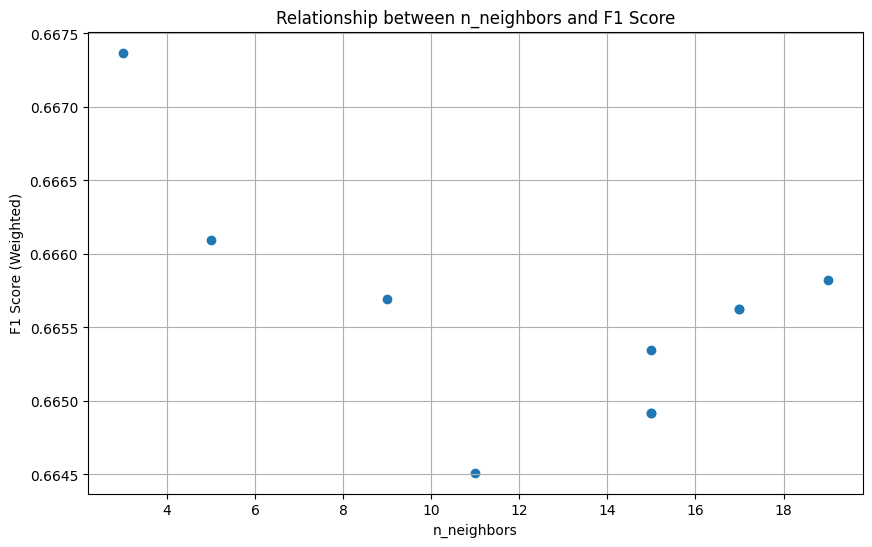

In [35]:
# Extract n_neighbors and corresponding F1 scores for each trial
n_neighbors_values = [trial.params['n_neighbors'] for trial in study.trials if trial.value is not None]
f1_scores = [trial.value for trial in study.trials if trial.value is not None]

# Plotting with Matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(n_neighbors_values, f1_scores)
plt.xlabel('n_neighbors')
plt.ylabel('F1 Score (Weighted)')
plt.title('Relationship between n_neighbors and F1 Score')
plt.grid(True)
plt.show()

In [36]:
# train the KNN model with the optimized hyperparameters
best_params = study.best_params

knn_model = neighbors.KNeighborsClassifier(
    n_neighbors=best_params['n_neighbors'],
    metric=best_params['metric'],
    weights='distance',
    n_jobs=-1  # Use all CPU cores for faster computation
)

knn_model.fit(X_train_resampled, y_train_resampled)

KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=3,
                     weights='distance')

In [37]:
# Make predictions on the test set
y_pred = knn_model.predict(X_test_pca)

In [38]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[984250 253007]
 [ 62487  43281]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.80      0.86   1237257
           1       0.15      0.41      0.22    105768

    accuracy                           0.77   1343025
   macro avg       0.54      0.60      0.54   1343025
weighted avg       0.88      0.77      0.81   1343025

